In [145]:
import pandas as pd
import geopandas as gpd
import glob
import os
import sys
import osmnx as ox
import networkx as nx
!{sys.executable} -m pip install h3
from h3 import h3

In [164]:
import matplotlib.pyplot as plt

In [75]:
path = r'../data/British Transport Police'
all_files = glob.glob(os.path.join(path , "*.csv"))
all_files


['../data/British Transport Police/2022-10-btp-street.csv',
 '../data/British Transport Police/2022-11-btp-street.csv',
 '../data/British Transport Police/2022-12-btp-street.csv',
 '../data/British Transport Police/2023-01-btp-street.csv',
 '../data/British Transport Police/2023-02-btp-street.csv',
 '../data/British Transport Police/2023-03-btp-street.csv',
 '../data/British Transport Police/2023-04-btp-street.csv',
 '../data/British Transport Police/2023-05-btp-street.csv',
 '../data/British Transport Police/2023-06-btp-street.csv',
 '../data/British Transport Police/2023-07-btp-street.csv',
 '../data/British Transport Police/2023-08-btp-street.csv',
 '../data/British Transport Police/2023-09-btp-street.csv']

In [79]:
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

dfs = pd.concat(li, axis=0, ignore_index=True)
# dfs = dfs.dropna(subset=['Crime type','Longitude','Latitude'])
dfs

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2022-10,British Transport Police,British Transport Police,-0.236429,50.832550,On or near Southwick (Station),E01031375,Adur 004G,Drugs,NaN,NaN
1,NaN,2022-10,British Transport Police,British Transport Police,-0.271753,50.834329,On or near Shoreham-By-Sea (Station),E01031364,Adur 005C,Public order,NaN,NaN
2,NaN,2022-10,British Transport Police,British Transport Police,-0.271753,50.834329,On or near Shoreham-By-Sea (Station),E01031364,Adur 005C,Public order,NaN,NaN
3,NaN,2022-10,British Transport Police,British Transport Police,-0.271753,50.834329,On or near Shoreham-By-Sea (Station),E01031364,Adur 005C,Violence and sexual offences,NaN,NaN
4,NaN,2022-10,British Transport Police,British Transport Police,-0.271753,50.834329,On or near Shoreham-By-Sea (Station),E01031364,Adur 005C,Violence and sexual offences,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
68802,NaN,2023-09,British Transport Police,British Transport Police,-4.258257,55.859590,On or near Glasgow Central (Station),NaN,NaN,Other crime,NaN,NaN
68803,NaN,2023-09,British Transport Police,British Transport Police,-4.258257,55.859590,On or near Glasgow Central (Station),NaN,NaN,Other crime,NaN,NaN
68804,NaN,2023-09,British Transport Police,British Transport Police,-4.258257,55.859590,On or near Glasgow Central (Station),NaN,NaN,Other crime,NaN,NaN
68805,NaN,2023-09,British Transport Police,British Transport Police,-4.424268,55.847372,On or near Paisley Gilmour Street (Station),NaN,NaN,Other crime,NaN,NaN


In [80]:
crimes = gpd.GeoDataFrame(
    dfs['Crime type'],
    geometry = gpd.points_from_xy(dfs.Longitude,dfs.Latitude),
    crs = "EPSG:4326"
)
print(crimes.head(5))

                     Crime type                   geometry
0                         Drugs  POINT (-0.23643 50.83255)
1                  Public order  POINT (-0.27175 50.83433)
2                  Public order  POINT (-0.27175 50.83433)
3  Violence and sexual offences  POINT (-0.27175 50.83433)
4  Violence and sexual offences  POINT (-0.27175 50.83433)


In [374]:
h3_level = 8

def lat_lng_to_h3(row):
    return h3.geo_to_h3(
        row.geometry.y, row.geometry.x, h3_level
    )

crimes["h3"] = crimes.apply(lat_lng_to_h3, axis = 1)

In [375]:
counts = (crimes.groupby(["h3"])
                .h3.agg("count")
                .to_frame("count")
                .reset_index()
)

counts_crime_type = (crimes.groupby(["h3",'Crime type'])
                .h3.agg("count")
                .to_frame("count")
                .reset_index()
                    )

print(counts.head(5))
print(counts_crime_type.head(5))

                h3  count
0  881870d109fffff      3
1  881870d243fffff     23
2  881870d335fffff     13
3  881870daa9fffff     32
4  881874048bfffff      1
                h3                    Crime type  count
0  881870d109fffff     Criminal damage and arson      1
1  881870d109fffff                   Other theft      1
2  881870d109fffff  Violence and sexual offences      1
3  881870d243fffff     Criminal damage and arson      8
4  881870d243fffff                         Drugs      1


In [379]:
from shapely.geometry import Polygon

def add_geometry(row):
    points = h3.h3_to_geo_boundary(
        row["h3"], True
    )
    return Polygon(points)

counts["geometry"] = counts.apply(add_geometry, axis = 1)
crimes_h3 = gpd.GeoDataFrame(counts, crs = "EPSG:4326")
print(crimes_h3.head(5))

counts_crime_type["geometry"] = counts_crime_type.apply(add_geometry, axis = 1)
crimes_type_h3 = gpd.GeoDataFrame(counts_crime_type, crs = "EPSG:4326")
print(crime_type_h3.head(5))

                h3  count                                           geometry
0  881870d109fffff      3  POLYGON ((-5.43979 50.17285, -5.44649 50.17127...
1  881870d243fffff     23  POLYGON ((-5.29138 50.21212, -5.29809 50.21055...
2  881870d335fffff     13  POLYGON ((-5.41717 50.19160, -5.42388 50.19002...
3  881870daa9fffff     32  POLYGON ((-5.52521 50.12581, -5.53191 50.12422...
4  881874048bfffff      1  POLYGON ((-4.48297 50.44627, -4.48968 50.44476...
                h3                    Crime type  count  \
0  881870d109fffff     Criminal damage and arson      1   
1  881870d109fffff                   Other theft      1   
2  881870d109fffff  Violence and sexual offences      1   
3  881870d243fffff     Criminal damage and arson      8   
4  881870d243fffff                         Drugs      1   

                                            geometry  
0  POLYGON ((-5.43979 50.17285, -5.44649 50.17127...  
1  POLYGON ((-5.43979 50.17285, -5.44649 50.17127...  
2  POLYGON ((-5.43

In [380]:
crimes_type_h3.to_file("../data/crimes_type_h3.gpkg", driver="GPKG")

In [377]:
crimes_h3.to_file("../data/crime_h3.gpkg", driver="GPKG")

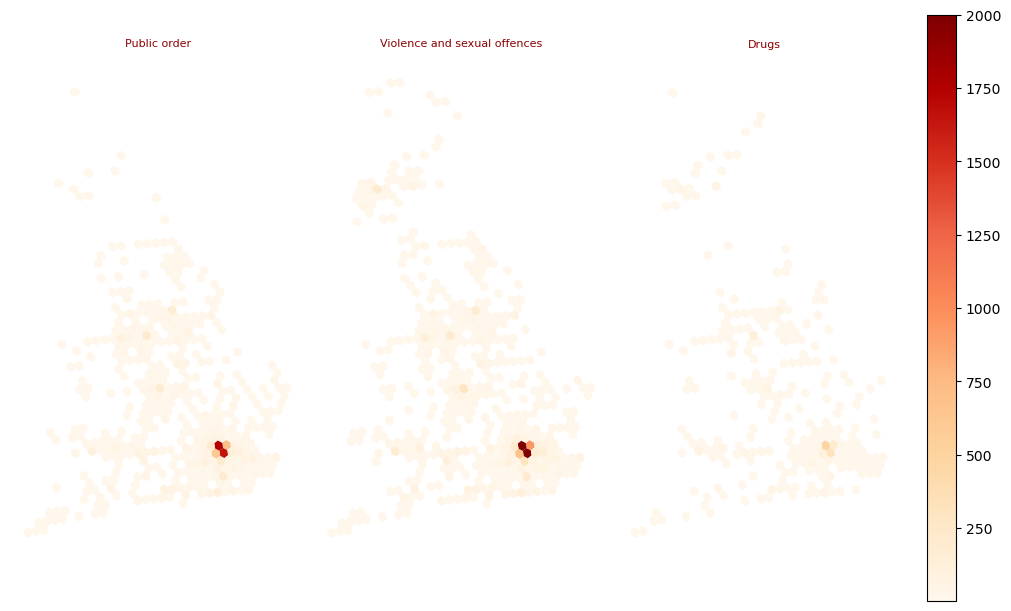

In [357]:
# Create figure and axes
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6),
                      facecolor='w',
                      constrained_layout=True,
                      sharex=True, sharey=True,
                      subplot_kw=dict(aspect='equal'))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Start the loop over all the variables of interest
for i, col in enumerate(crime_types):
    # select the axis where the map will go
    ax = axs[i]
    # last item?
    tf = type(bool)
    if i != len(crime_types)-1:
        tf = False # no legend
    else:
        tf = True # yes legend
    
    # Plot the map
    crime_type_h3[crime_type_h3['Crime type']==col].plot(
        column = "count",
        ax=ax,
        cmap = "OrRd",
        vmax=2000,
        legend = tf
    )
    #Scheme must be in the set: dict_keys(['boxplot', 'equalinterval', 'fisherjenks', 'fisherjenkssampled', 'headtailbreaks', 'jenkscaspall', 'jenkscaspallforced', 'jenkscaspallsampled', 'maxp', 'maximumbreaks', 'naturalbreaks', 'quantiles', 'percentiles', 'stdmean', 'userdefined'])
    
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of the variable being plotted
    ax.set_title(col,
                 y=1,
                fontdict={
                     'fontsize': 8,
                    'fontweight' :10,
                    'color' : 'darkred'                    
                }
    )
# Display the figure
plt.show()